# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, root_mean_squared_error
import seaborn as sns
import kagglehub
from datetime import datetime


/Users/joselopez/compSci/MLCSE176/CSE176MLProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regression with Tensorflow Decision Forests

## Download and store data into a dataframe 

In [2]:
# Download latest version
path = kagglehub.dataset_download("mssmartypants/paris-housing-price-prediction")

print("Path to dataset files:", path)

Path to dataset files: /Users/joselopez/.cache/kagglehub/datasets/mssmartypants/paris-housing-price-prediction/versions/2


In [3]:
dfHousing = pd.read_csv(os.path.join(path, "ParisHousing.csv"))
dfHousing.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [4]:
dfSize = np.shape(dfHousing)
print(dfSize)
n = dfSize[0]
col = dfSize[1]

(10000, 17)


## Preprocessing

In [5]:
# check for NA values
print(dfHousing.isna().sum())

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64


No NA values so continue

In [6]:
# add current age of house instead of the year the house was built in regression it can be seen as increase in age leads to decrease in price
currYear = int(datetime.now().year)
print(currYear)
dfHousing['age'] = currYear - dfHousing['made']
print(dfHousing['age'])
dfHousing = dfHousing.drop(columns='made')
dfHousing.head()

2025
0       20
1       10
2        4
3       13
4       35
        ..
9995    16
9996    35
9997    20
9998    15
9999    31
Name: age, Length: 10000, dtype: int64


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,age
0,75523,3,0,1,63,9373,3,8,0,1,4313,9005,956,0,7,7559081.5,20
1,80771,39,1,1,98,39381,8,6,1,0,3653,2436,128,1,2,8085989.5,10
2,55712,58,0,1,19,34457,6,8,0,0,2937,8852,135,1,9,5574642.1,4
3,32316,47,0,0,6,27939,10,4,0,1,659,7141,359,0,3,3232561.2,13
4,70429,19,1,1,90,38045,3,7,1,0,8435,2429,292,1,4,7055052.0,35


Look at correlation of the data

                   squareMeters  numberOfRooms   hasYard   hasPool    floors  \
squareMeters           1.000000       0.009573 -0.006650 -0.005594  0.001109   
numberOfRooms          0.009573       1.000000 -0.011240  0.017015  0.022244   
hasYard               -0.006650      -0.011240  1.000000  0.015514 -0.000883   
hasPool               -0.005594       0.017015  0.015514  1.000000 -0.004006   
floors                 0.001109       0.022244 -0.000883 -0.004006  1.000000   
cityCode              -0.001541       0.009040  0.006760  0.008072  0.002207   
cityPartRange          0.008758       0.008340  0.005023  0.014613 -0.004921   
numPrevOwners          0.016619       0.016766  0.004279 -0.006848  0.002463   
isNewBuilt            -0.010667      -0.002865 -0.008370  0.000188  0.002458   
hasStormProtector      0.007480      -0.001656 -0.007598 -0.001001 -0.008566   
basement              -0.003960      -0.013990 -0.008558 -0.007268  0.006228   
attic                 -0.000588       0.

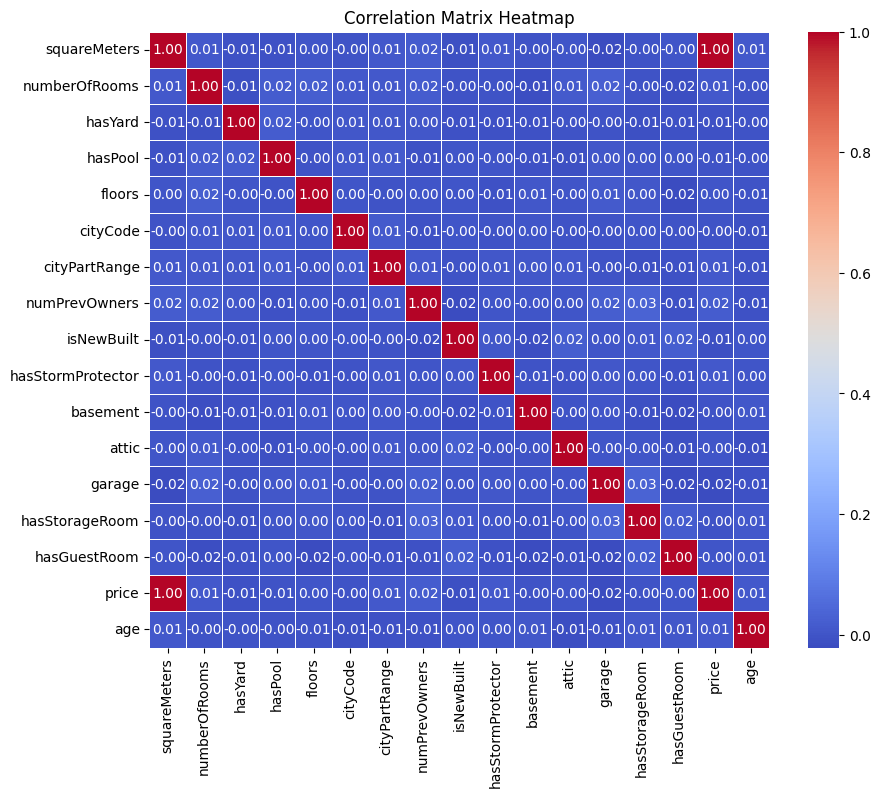

In [7]:
correlation_matrix = dfHousing.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Notice price and squareMeters are highly correlated.

# Train first model

In [8]:
# split data
dfHousing.head()
x_train, x_test, y_train, y_test = train_test_split(dfHousing.drop(columns=['price']), dfHousing['price'], test_size = 0.2, random_state = 67)
print(np.shape(x_train))
print(np.shape(x_test))


# convert to tensorflow datasets
x_train['price'] = y_train
x_test['price'] = y_test


dfTrain = x_train
dfTest = x_test
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dfTrain, label="price", task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dfTest, label="price", task=tfdf.keras.Task.REGRESSION)


(8000, 16)
(2000, 16)


In [9]:

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION)

# Train the model.
model_1.fit(train_ds)

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpmh7m65_l as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [10]:
model_1.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (16):
	age
	attic
	basement
	cityCode
	cityPartRange
	floors
	garage
	hasGuestRoom
	hasPool
	hasStorageRoom
	hasStormProtector
	hasYard
	isNewBuilt
	numPrevOwners
	numberOfRooms
	squareMeters

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.      "squareMeters"  0.466586 ################
    2.          "cityCode"  0.122073 #
    3.          "basement"  0.117388 #
    4.            "garage"  0.113284 #
    5.             "attic"  0.110225 #
    6.     "numberOfRooms"  0.107122 #
    7.               "age"  0.103194 #
    8.            "floors"  0.103126 #
    9.     "numPrevOwners"  0.08

In [11]:
model_1.compile(metrics=['mse'])
evaluation = model_1.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_1.make_inspector()
print(inspector.evaluation())


2/2 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - mse: 6489231360.0000

loss: 0.0000
mse: 6489231360.0000
The RMSE of this testing evaluation is: 80555.76552922826
Evaluation(num_examples=8000, accuracy=None, loss=None, rmse=84243.14444155284, ndcg=None, aucs=None, auuc=None, qini=None)


### The given RMSE is the predicted error from the true value of a house on average

In [12]:
model_1000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=1000)

# Train the model.
model_1000.fit(train_ds)

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmp8s84ehw1 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [13]:
model_1000.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (16):
	age
	attic
	basement
	cityCode
	cityPartRange
	floors
	garage
	hasGuestRoom
	hasPool
	hasStorageRoom
	hasStormProtector
	hasYard
	isNewBuilt
	numPrevOwners
	numberOfRooms
	squareMeters

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.      "squareMeters"  0.466548 ################
    2.          "cityCode"  0.120848 #
    3.          "basement"  0.117340 #
    4.            "garage"  0.113416 #
    5.             "attic"  0.109671 #
    6.     "numberOfRooms"  0.107468 #
    7.               "age"  0.104921 #
    8.            "floors"  0.103368 #
    9.     "numPrevOwners"  0.

In [14]:
model_1000.compile(metrics=['mse'])
evaluation = model_1000.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_1000.make_inspector()
print(inspector.evaluation())

2/2 [==============================] - 0s 190ms/step - loss: 0.0000e+00 - mse: 6293806080.0000

loss: 0.0000
mse: 6293806080.0000
The RMSE of this testing evaluation is: 79333.51170848294
Evaluation(num_examples=8000, accuracy=None, loss=None, rmse=78527.08471678269, ndcg=None, aucs=None, auuc=None, qini=None)


In [15]:
model_2000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2000)

# Train the model.
model_2000.fit(train_ds)
model_2000.summary()
model_2000.compile(metrics=['mse'])
evaluation = model_2000.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_2000.make_inspector()
print(inspector.evaluation())

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmp20hq4584 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [16]:
model_3000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=3000)

# Train the model.
model_3000.fit(train_ds)
model_3000.summary()
model_3000.compile(metrics=['mse'])
evaluation = model_3000.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")

inspector = model_3000.make_inspector()
print(inspector.evaluation())

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmph7oucgwp as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

### Testing RMSE went up so try num_tree between 2000 3000

In [17]:
testRMSE = []
for i in range(2100, 3001, 100):
    model = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=i)
    model.fit(train_ds)
    model.compile(metrics=['mse'])
    evaluation = model.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
    testRMSE.append(np.sqrt(evaluation['mse']))
testRMSE = np.array(testRMSE)
minRMSE = np.min(testRMSE)
minIdx = np.argmin(testRMSE)
print(f"At Idx: {minIdx} the minRMSE is {minRMSE}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpdapma8t4 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

Training dataset read in 0:00:00.124836. Found 8000 examples.
Training model...
Model trained in 0:00:17.400702
Compiling model...


Model compiled.


2/2 [==============================] - 1s 461ms/step - loss: 0.0000e+00 - mse: 6447019520.0000
Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpwoihibup as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic'

Training dataset read in 0:00:00.125411. Found 8000 examples.
Training model...
Model trained in 0:00:17.699521
Compiling model...


Model compiled.


2/2 [==============================] - 1s 501ms/step - loss: 0.0000e+00 - mse: 6436916736.0000
Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpqs4th8b9 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic'

WE notice about 2200 trees it gives us the lowest Test RMSE so we will see if we should decrease or increase it by a bit.

In [18]:
model_2250 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2250)
model_2250.fit(train_ds)
model_2250.compile(metrics=['mse'])
evaluation = model_2250.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2250 tress: {np.sqrt(evaluation['mse'])}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmp3x54jbwj as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

It increase so try decreasing it.

In [19]:
model_2150 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2150)
model_2150.fit(train_ds)
model_2150.compile(metrics=['mse'])
evaluation = model_2150.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2150 tress: {np.sqrt(evaluation['mse'])}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmp4u1hdfp_ as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [20]:
model_2190 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2190)
model_2190.fit(train_ds)
model_2190.compile(metrics=['mse'])
evaluation = model_2190.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2190 tress: {np.sqrt(evaluation['mse'])}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpt7jkjvq7 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [21]:
model_2210 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2210)
model_2210.fit(train_ds)
model_2210.compile(metrics=['mse'])
evaluation = model_2210.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2210 tress: {np.sqrt(evaluation['mse'])}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmppkrrs6f5 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

Seems that 2200 is the best number of trees with the default depth. Lets try to increase and decrease the max depth

In [22]:
depth = 20
model_2200 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2200, max_depth=depth)
model_2200.fit(train_ds)
model_2200.compile(metrics=['mse'])
evaluation = model_2200.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2200 tress depth {depth}: {np.sqrt(evaluation['mse'])}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmprqncse3k as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

About 20 to 21 max depth with 2200 number of trees it gives the lowest test RMSE fo 80601.62

This gives the first 1 tree of the model up to depth 4. Must be opened.

In [23]:

html_code = tfdf.model_plotter.plot_model(model_1, max_depth=4)

with open("tree.html", "w") as f:
    f.write(html_code)


### Now try seeing what is the best number of trees with default depth (10000)

In [24]:
model_10000 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=10000)

# Train the model.
model_10000.fit(train_ds)
    

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmp00ws317g as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [25]:
model_10000.compile(metrics=['mse'])
evaluation = model_10000.evaluate(test_ds, return_dict=True, use_multiprocessing=True,)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")
print(f"The RMSE of this testing evaluation is: {np.sqrt(evaluation['mse'])}")


2/2 [==============================] - 8s 4s/step - loss: 0.0000e+00 - mse: 6435414016.0000

loss: 0.0000
mse: 6435414016.0000
The RMSE of this testing evaluation is: 80221.03225464006


In [26]:
inspector = model_10000.make_inspector()
print(inspector.variable_importances())

{'INV_MEAN_MIN_DEPTH': [("squareMeters" (1; #16), 0.4467434715672249), ("cityCode" (1; #4), 0.12059329073989856), ("basement" (1; #3), 0.11799396987165683), ("garage" (1; #7), 0.11354427560981174), ("attic" (1; #2), 0.11099922350942558), ("numberOfRooms" (1; #15), 0.10832385035570034), ("age" (1; #1), 0.10632748068683183), ("floors" (1; #6), 0.1031875917150602), ("numPrevOwners" (1; #14), 0.09159127707715019), ("cityPartRange" (1; #5), 0.08821171930979062), ("hasGuestRoom" (1; #8), 0.0872815867366202), ("hasPool" (1; #9), 0.07838898191683945), ("hasYard" (1; #12), 0.0780887012894307), ("hasStormProtector" (1; #11), 0.0778822941985474), ("isNewBuilt" (1; #13), 0.07763458845022844), ("hasStorageRoom" (1; #10), 0.0773904370503613)], 'SUM_SCORE': [("squareMeters" (1; #16), 6.462389751414591e+20), ("basement" (1; #3), 1.4142880744497183e+18), ("cityCode" (1; #4), 1.4125456389379712e+18), ("attic" (1; #2), 1.3423539565692705e+18), ("garage" (1; #7), 1.3144585103685975e+18), ("numberOfRooms" 

In [27]:
y_pred_test = model_10000.predict(test_ds)
testRMSE = root_mean_squared_error(y_test, y_pred_test)
print(testRMSE)

2/2 [==============================] - 8s 4s/step
80221.03235402361


In [28]:
model_2700 = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, num_trees=2700, max_depth=20)
model_2700.fit(train_ds)
model_2700.compile(metrics=['mse'])
evaluation = model_2700.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of 2700 tress depth {depth}: {np.sqrt(evaluation['mse'])}")

Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpv080ikce as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, 'hasStormProtector': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'basement': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'attic': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, 'garage': <tf.Tensor 'data_12:0' shape=(No

In [42]:
model_hyperparameters = tfdf.keras.RandomForestModel(verbose=2, task=tfdf.keras.Task.REGRESSION, hyperparameter_template="benchmark_rank1")
model_hyperparameters.fit(train_ds)
model_hyperparameters.compile(metrics=['mse'])
evaluation = model_hyperparameters.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of better default tress: {np.sqrt(evaluation['mse'])}")


Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpqvnxoktl as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' s

## THis is the new lowest for test RMSE of 54557.12367784797

In [43]:
inspector = model_hyperparameters.make_inspector()
numTrees = inspector.num_trees()
print(numTrees)

300


In [51]:
model_hyperparameters = tfdf.keras.RandomForestModel(verbose=2,  num_trees=2200, max_depth=20, task=tfdf.keras.Task.REGRESSION, hyperparameter_template="benchmark_rank1")
model_hyperparameters.fit(train_ds)
model_hyperparameters.compile(metrics=['mse'])
evaluation = model_hyperparameters.evaluate(test_ds, return_dict=True, use_multiprocessing=True)
print(f"Test RMSE of better default tress: {np.sqrt(evaluation['mse'])}")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use 8 thread(s) for training
Use /var/folders/mc/wq5f55xs1cd3b2bqkzfys5j80000gn/T/tmpy9zram7v as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'squareMeters': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'numberOfRooms': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, 'hasYard': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'hasPool': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'floors': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'cityCode': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'cityPartRange': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, 'numPrevOwners': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'isNewBuilt': <tf.Tensor 'data_8:0' s